In [13]:
# default_exp analyses

# Probability of First Recall in Repetition Data
Here we extend on previous implementations to ensure recall rates are successfully measured and visualized when study lists can include two presentations of study items. 

**NOTE**: function not yet tested for lists with more than two presentations per item within a study list.

## Data Preparation

In [14]:
from compmemlearn.datasets import prepare_lohnas2014_data

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,condition,first_input
0,1,1,0,1,1.0,True,True,0,False,4,1
1,1,1,1,2,2.0,True,True,0,False,4,2
2,1,1,2,3,3.0,True,True,0,False,4,3
3,1,1,3,4,4.0,True,True,0,False,4,4
4,1,1,4,5,5.0,True,True,0,False,4,5


## Function

In [15]:
from compmemlearn.analyses import recall_by_second_study_position
from compmemlearn.analyses import recall_by_all_study_positions

In [16]:
# export

from numba import njit
import numpy as np
from numba import int32

@njit(nogil=True)
def fast_mixed_pfr(trials, presentations):
    
    list_length = len(presentations[0])
    result = np.zeros(list_length, dtype=int32)
    alt_trials = recall_by_second_study_position(trials, presentations)
    first_recalls = np.hstack((trials[:, :1], alt_trials[:, :1]))
    
    for trial_index in range(len(trials)):
        for i in range(list_length):
            result[i] += i+1 in first_recalls[trial_index]
    
    return result/len(trials)

@njit(nogil=True)
def flex_mixed_pfr(trials, presentations):
    
    list_length = len(presentations[0])
    result = np.zeros(list_length, dtype=int32)
    all_study_positions = recall_by_all_study_positions(trials, presentations) 
    first_recalls = all_study_positions[:, :, :1]
    
    for trial_index in range(len(trials)):
        for i in range(list_length):
            result[i] += i+1 in first_recalls[:, trial_index]
    
    return result/len(trials)


In [17]:
# export

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from compmemlearn.datasets import events_metadata, generate_trial_mask


def plot_flex_pfr(data, trial_query, contrast_name='', labels=None, axis=None):

    if axis is None:
        plt.figure()
        axis = plt.gca()

    if labels is None:
        labels = [''] * len(data)

    result = []
    for data_index, events in enumerate(data):

        # generate and subset trials array and list of list_lengths based on trial_query
        trials, list_lengths, presentations = events_metadata(events)
        trial_mask = generate_trial_mask(events, trial_query)
        chose = [i for i in range(len(trial_mask)) if np.sum(trial_mask[i]) != 0]
        assert(len(chose) == 1)
        chose = chose[0]
        trials = trials[chose]
        list_length = list_lengths[chose]
        presentations = presentations[chose]
        trial_mask = trial_mask[chose]

        for subject in pd.unique(events.subject):
            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f"subject == {subject}")[chose], trial_mask
            )

            if np.sum(subject_specific_trial_mask) == 0:
                continue

            pfr = flex_mixed_pfr(trials[subject_specific_trial_mask], presentations[subject_specific_trial_mask])
            result.append(pd.DataFrame.from_dict(
                {
                    "subject": subject,
                    "input": np.arange(1, list_length + 1),
                    "recall": pfr,
                    contrast_name: labels[data_index],
                }
            ))

    result = pd.concat(result).reset_index()

    sns.lineplot(ax=axis, data=result, x='input', y='recall', err_style='bars', hue=contrast_name)
    axis.set(xlabel='Study Position', ylabel='Recall Rate')
    axis.set_xticks(np.arange(1, list_length+int(list_length/10), int(list_length/10)))
    axis.set_ylim((0, 1))

    if contrast_name:
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return axis

## Demo

In [18]:
fast_mixed_pfr(trials[list_types==1], presentations[list_types==1])

array([0.21666667, 0.06190476, 0.03333333, 0.04047619, 0.00952381,
       0.01666667, 0.        , 0.02142857, 0.01190476, 0.01190476,
       0.01428571, 0.01428571, 0.0047619 , 0.00714286, 0.00952381,
       0.00238095, 0.00952381, 0.01190476, 0.0047619 , 0.00952381,
       0.0047619 , 0.01428571, 0.00952381, 0.00714286, 0.01190476,
       0.01190476, 0.00952381, 0.02142857, 0.01428571, 0.01190476,
       0.02619048, 0.01190476, 0.01428571, 0.01904762, 0.01190476,
       0.03571429, 0.05238095, 0.06190476, 0.06428571, 0.07380952])

In [19]:
flex_mixed_pfr(trials[list_types==1], presentations[list_types==1])

array([0.21666667, 0.06190476, 0.03333333, 0.04047619, 0.00952381,
       0.01666667, 0.        , 0.02142857, 0.01190476, 0.01190476,
       0.01428571, 0.01428571, 0.0047619 , 0.00714286, 0.00952381,
       0.00238095, 0.00952381, 0.01190476, 0.0047619 , 0.00952381,
       0.0047619 , 0.01428571, 0.00952381, 0.00714286, 0.01190476,
       0.01190476, 0.00952381, 0.02142857, 0.01428571, 0.01190476,
       0.02619048, 0.01190476, 0.01428571, 0.01904762, 0.01190476,
       0.03571429, 0.05238095, 0.06190476, 0.06428571, 0.07380952])

In [20]:
fast_mixed_pfr(trials[list_types==2], presentations[list_types==2])

array([0.34761905, 0.34761905, 0.06904762, 0.06904762, 0.0452381 ,
       0.0452381 , 0.03333333, 0.03333333, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01428571, 0.01428571, 0.01666667,
       0.01666667, 0.01190476, 0.01190476, 0.02380952, 0.02380952,
       0.01666667, 0.01666667, 0.01904762, 0.01904762, 0.02142857,
       0.02142857, 0.02619048, 0.02619048, 0.03333333, 0.03333333,
       0.03095238, 0.03095238, 0.04047619, 0.04047619, 0.04285714,
       0.04285714, 0.06904762, 0.06904762, 0.1       , 0.1       ])

In [21]:
flex_mixed_pfr(trials[list_types==2], presentations[list_types==2])

array([0.34761905, 0.34761905, 0.06904762, 0.06904762, 0.0452381 ,
       0.0452381 , 0.03333333, 0.03333333, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01428571, 0.01428571, 0.01666667,
       0.01666667, 0.01190476, 0.01190476, 0.02380952, 0.02380952,
       0.01666667, 0.01666667, 0.01904762, 0.01904762, 0.02142857,
       0.02142857, 0.02619048, 0.02619048, 0.03333333, 0.03333333,
       0.03095238, 0.03095238, 0.04047619, 0.04047619, 0.04285714,
       0.04285714, 0.06904762, 0.06904762, 0.1       , 0.1       ])

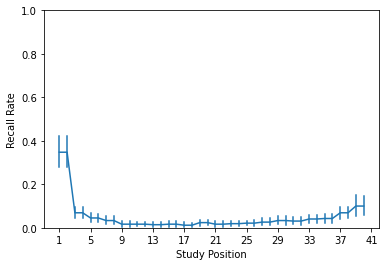

In [22]:
import matplotlib.pyplot as plt

plt.figure()
axis = plt.gca()
plot_flex_pfr([events], 'condition == 2', axis=axis);

In [23]:
fast_mixed_pfr(trials[list_types==3], presentations[list_types==3])

array([0.24285714, 0.06428571, 0.05      , 0.06428571, 0.09285714,
       0.06428571, 0.04047619, 0.04285714, 0.0547619 , 0.05238095,
       0.03333333, 0.01904762, 0.02380952, 0.01666667, 0.03095238,
       0.03809524, 0.01428571, 0.00714286, 0.01904762, 0.02857143,
       0.01428571, 0.02857143, 0.01428571, 0.02619048, 0.02142857,
       0.01666667, 0.02619048, 0.02142857, 0.0452381 , 0.03809524,
       0.0452381 , 0.03095238, 0.05      , 0.0547619 , 0.07142857,
       0.09285714, 0.06666667, 0.11428571, 0.0952381 , 0.09761905])

In [24]:
fast_mixed_pfr(trials[list_types==4], presentations[list_types==4])

array([0.21190476, 0.04285714, 0.05      , 0.02142857, 0.02857143,
       0.02857143, 0.01904762, 0.01666667, 0.01666667, 0.02619048,
       0.01666667, 0.03809524, 0.02380952, 0.02619048, 0.01428571,
       0.01190476, 0.01190476, 0.01666667, 0.01428571, 0.00952381,
       0.01666667, 0.02142857, 0.0047619 , 0.00952381, 0.01666667,
       0.02142857, 0.00952381, 0.03095238, 0.03333333, 0.01428571,
       0.02142857, 0.02380952, 0.02857143, 0.03571429, 0.02857143,
       0.04761905, 0.03333333, 0.05714286, 0.04047619, 0.04285714])